# Imports

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import initialization
import simulation
from ofc import System

# SMD Implementation in the SCN paper

## Simulation Parameters

In [2]:
# Simulation time and timestep (using Forward Euler)
total_time = 50          # seconds, total duration of the simulation
dt = 0.001               # seconds, timestep size
times, Nt = initialization.FE_init(total_time, dt)  # creates time array and total steps (Nt)

## SMD System Parameters

In [3]:
# Spring-Mass-Damper (SMD) physical parameters
m = 3        # mass (kg)
k = 5        # spring constant (N/m)
c = 0.5      # damping coefficient (kg/s)
x0 = np.array([5, 0])  # initial state: position = 5 m, velocity = 0 m/s

# Observation (sensor) matrix:
# Here we assume that we only observe the position. The second row is used for consistency (could be zero).
C = np.array([[1, 0],
              [0, 0]])

# Noise covariances for the SMD system
Vn_cov = 0.001  # sensor noise covariance (for measurements y)
Vd_cov = 0.001  # process disturbance noise covariance (for system dynamics)

## SCN Estimator Parameters

In [4]:
network_size = 20       # number of neurons in our SCN estimator
signal_dim = 2          # dimensionality of the state (here position and velocity)
lam = 0.1               # leakage constant (lambda) for the network dynamics
Vv_sigma = 1e-6         # noise on the neuron voltage (standard deviation)

## Initialize the System and Networks

In [5]:
# (a) Initialize the SMD system matrices using state-space form:
A, B = initialization.SMD_init(m, k, c)
# Print controllability rank to check that the system is controllable

# (b) Initialize the Kalman filter gain matrix (Kf) for the estimator
Kf = initialization.Kalman_init(A, C, Vn_cov, Vd_cov)

# (c) Initialize the state history for the SMD system:
X = initialization.X_init(x0, Nt)

# (d) Initialize the SCN Kalman filter network for estimation:
# The function returns:
#   D: decoding matrix (neurons → state estimate)
#   T: thresholds (derived from D)
#   V: initial voltage vector for neurons over time
#   s: spike train matrix (each neuron's spike output over time)
#   r: filtered spike rates (the “neural firing rate” representation)
#   O_f: fast recurrent connectivity matrix
#   O_s: slow recurrent connectivity matrix (implements system dynamics)
#   F_i: feedforward input connectivity (maps external input to neurons)
#   O_k: recurrent “Kalman” connectivity (for update using observation)
#   F_k: feed-forward "Kalman" connectivity (maps sensory input into the network)
D, T_vals, V, s, r, O_f, O_s, F_i, O_k, F_k = initialization.KfSCN_init(
    signal_dim, Nt, A, B, C, Kf, network_size, lam)

# (e) Initialize additional loop arrays used during simulation:
# U: control input (not used in pure estimation example here)
# Y: observation (measurement of system state, y = Cx + noise)
# X_hat: state estimates from our SCN estimator
# X_hat_fe: state estimates from an idealized (non-spiking) Kalman filter for comparison
# uDIST and uNOISE: random disturbances for process and observation noises
U, Y, X_hat, X_hat_fe, uDIST, uNOISE = initialization.KfLoop_init(
    X, A, B, C, x0, Nt, Vd_cov, Vn_cov)

Rank of controllability-matrix: 2


## Run the Simulation (Estimation)

<Figure size 1200x800 with 0 Axes>

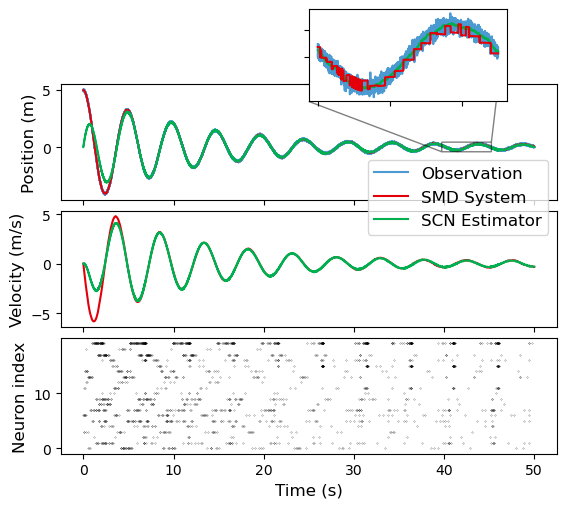

In [6]:
def run_simulation(Nt, X, A, B, U, uDIST, dt, Y, C, uNOISE,
                   r, s, V, D, T_vals, lam, O_f, O_s, F_i, O_k, F_k, Vv_sigma,
                   X_hat, X_hat_fe, Kf):
    """
    Runs the simulation for the SMD system using:
      - A non-learning SCN estimator (fixed gains) implementing a Kalman filter.
      - An idealized Kalman filter for comparison.
    
    Updates:
      - System state (X) via a linearized DS step.
      - Observations (Y) with added noise.
      - The SCN network's internal state (r, s, V) via run_KfSCN_step.
      - Decoded state estimate (X_hat) from the SCN.
      - Idealized Kalman filter state (X_hat_fe) via run_Kfidealized_step.
    """
    for t in range(Nt):
        # 1. Update the real system state X using the linearized dynamics:
        X[:, t+1] = simulation.run_DSlinearized_step(X[:, t], A, B, U[:, t], uDIST[:, t], dt)
        
        # 2. Get the new observation Y: y = C x + sensor noise.
        Y[:, t+1] = C @ X[:, t+1] + uNOISE[:, t+1]
        
        # 3. Run one step of the SCN Kalman filter network:
        r[:, t+1], s[:, t+1], V[:, t+1] = simulation.run_KfSCN_step(
            Y[:, t], U[:, t], r[:, t], s[:, t], V[:, t],
            D, T_vals, lam, O_f, O_s, F_i, O_k, F_k, C, t, dt, Vv_sigma)
        
        # 4. Decode the state estimate from the SCN network:
        X_hat[:, t+1] = D @ r[:, t+1]
        
        # 5. Update the idealized (non-spiking) Kalman filter estimate for comparison:
        X_hat_fe[:, t+1] = simulation.run_Kfidealized_step(X_hat_fe[:, t], A, B, U[:, t], Kf, Y[:, t], C, dt)
        
        # 6. In this estimation example, there is no external control so we set U to zero.
        U[0, t+1] = 0
    
    return X_hat, X_hat_fe, X, Y, s

# Run the simulation and collect trajectories:
X_hat, X_hat_fe, X_sim, Y_sim, s_sim = run_simulation(
    Nt, X, A, B, U, uDIST, dt, Y, C, uNOISE,
    r, s, V, D, T_vals, lam, O_f, O_s, F_i, O_k, F_k, Vv_sigma,
    X_hat, X_hat_fe, Kf)

# Plot the Results
time = total_time

# Create the figure and subplots.
fig = plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(3, 1, sharex=True, squeeze=True,
                        gridspec_kw={'hspace': 0.1, 'height_ratios': [1, 1, 1]})
legend_fontsize = 12

# Create a time vector for plotting based on dt and simulation time.
t_vec = np.arange(0, time + dt, dt)

# Top Plot: Compare Observation, True SMD System, and SCN Estimator (Position)
legend_labels = []
axs[0].plot(t_vec, Y_sim[0], color='#0070C0', alpha=0.7, label="Observation")
legend_labels.append("Observation")
axs[0].plot(t_vec, X_sim[0], color='#E3000B', label="SMD System")
legend_labels.append("SMD System")
axs[0].plot(t_vec, X_hat[0], color='#00B050', label="SCN Estimator")
legend_labels.append("SCN Estimator")

# Middle Plot: Velocity (True vs. Estimate)
axs[1].plot(t_vec, X_sim[1], color='#E3000B', label="SMD System")
axs[1].plot(t_vec, X_hat[1], color='#00B050', label="SCN Estimator")
# We add a legend once for the whole figure in the top plot.
fig.legend(legend_labels, fontsize=legend_fontsize,
           loc='upper right', bbox_to_anchor=(0.90, 0.74))

# Label the axes.
axs[0].set_ylabel('Position (m)', fontsize=12)
axs[1].set_ylabel('Velocity (m/s)', fontsize=12)

# Bottom Plot: Raster Plot of Spiking Activity
# We assume s_sim is a 2D array with shape (n_neurons, Nt+1)
neuron_indices, spike_times = np.nonzero(s_sim)
axs[2].scatter(spike_times * dt, neuron_indices,
               marker=".", s=0.1, color='black')
axs[2].set_xlabel('Time (s)', fontsize=12)
axs[2].set_ylabel('Neuron index', fontsize=12)

# Create an inset in the top plot to zoom in on a specific time window.
axins = axs[0].inset_axes([0.5, 0.85, 0.4, 0.8])
# Define the range of indices to plot in the inset:
range_plot_x, range_plot_y = 40000, 45000  # adjust these values as needed
axins.plot(t_vec[range_plot_x:range_plot_y], Y_sim[0, range_plot_x:range_plot_y],
           color='#0070C0', alpha=0.7)
axins.plot(t_vec[range_plot_x:range_plot_y], X_sim[0, range_plot_x:range_plot_y],
           color='#00B050')
axins.plot(t_vec[range_plot_x:range_plot_y], X_hat[0, range_plot_x:range_plot_y],
           color='#E3000B')
axins.set_xticklabels([])
axins.set_yticklabels([])

# Draw the zoom box indicator on the main plot.
axs[0].indicate_inset_zoom(axins, edgecolor="black")

# Save the figure and show it.
plt.savefig('./img/original.png', facecolor='white', transparent=False,
            dpi=300, bbox_inches='tight')
plt.show()

In [18]:
def plot_scenario_results(
    scenario_res, 
    D, 
    dt, 
    total_time,
    title="SCN Scenario",
    zoom=False
):
    """
    Plots position, velocity, and raster for a given scenario's results.
    
    Parameters
    ----------
    scenario_res : dict
        The dictionary returned by run_scn_episode, containing:
          - 'X': real SMD system states, shape (2, Nt+1)
          - 'Y': observations, shape (2, Nt+1)
          - 'r': SCN firing rates, shape (N, Nt+1)
          - 's': SCN spikes, shape (N, Nt+1)
          - possibly other entries like cost, etc.
    D : ndarray, shape (2, N)
        Decoding matrix that maps SCN firing rates to the 2D state estimate (position, velocity).
    dt : float
        Time step (e.g. 0.001).
    total_time : float
        Total simulation time in seconds (Nt * dt).
    title : str
        A title or label for the scenario, e.g. "Estimation Only (Fixed Kf)".
    """
    # Extract from scenario results
    X_real = scenario_res['X']         # shape (2, Nt+1)
    Y_obs = scenario_res['Y']          # shape (2, Nt+1)
    r_scn = scenario_res['r']          # shape (N, Nt+1)
    s_spikes = scenario_res['s']       # shape (N, Nt+1)

    Nt = X_real.shape[1] - 1  # e.g. total timesteps
    t_vec = np.arange(0, total_time+dt, dt)

    # Decode the SCN estimate: X_hat = D @ r at each time
    # shape(2, Nt+1)
    X_hat_scn = np.zeros_like(X_real)
    for t in range(Nt+1):
        X_hat_scn[:, t] = D @ r_scn[:, t]

    # Create the figure
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8),
                            gridspec_kw={'hspace': 0.1, 'height_ratios': [1, 1, 1]})
    legend_fontsize = 12

    # --- Top Plot: Position ---
    axs[0].plot(t_vec, Y_obs[0], color='#0070C0', alpha=0.7, label="Observation")
    axs[0].plot(t_vec, X_real[0], color='#E3000B', label="SMD System")
    axs[0].plot(t_vec, X_hat_scn[0], color='#00B050', label="SCN Estimator")
    axs[0].set_ylabel('Position (m)', fontsize=12)
    axs[0].legend(fontsize=legend_fontsize, loc='upper right')

    # --- Middle Plot: Velocity ---
    axs[1].plot(t_vec, X_real[1], color='#E3000B', label="SMD System")
    axs[1].plot(t_vec, X_hat_scn[1], color='#00B050', label="SCN Estimator")
    axs[1].set_ylabel('Velocity (m/s)', fontsize=12)
    axs[1].legend(fontsize=legend_fontsize, loc='upper right')

    # --- Bottom Plot: Raster of spikes ---
    neuron_indices, spike_times = np.nonzero(s_spikes)
    axs[2].scatter(spike_times * dt, neuron_indices,
                   marker=".", s=0.2, color='black')
    axs[2].set_xlabel('Time (s)', fontsize=12)
    axs[2].set_ylabel('Neuron index', fontsize=12)

    if zoom:
        range_plot_x, range_plot_y = 40000, 45000
        if range_plot_y <= Nt+1:
            axins = axs[0].inset_axes([0.5, 0.5, 0.47, 0.47])
            axins.plot(t_vec[range_plot_x:range_plot_y], Y_obs[0, range_plot_x:range_plot_y],
                       color='#0070C0', alpha=0.7)
            axins.plot(t_vec[range_plot_x:range_plot_y], X_real[0, range_plot_x:range_plot_y],
                       color='#E3000B')
            axins.plot(t_vec[range_plot_x:range_plot_y], X_hat_scn[0, range_plot_x:range_plot_y],
                       color='#00B050')
            axs[0].indicate_inset_zoom(axins, edgecolor="black")
    
    axs[0].set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Extend run_KfSCN_step with Online Learning

In [8]:
def run_KfSCN_step_learn(
        y, u, r, s, v,
        D, T_vals, lam,
        O_f, O_s, F_i,
        O_k, F_k,       # these will be updated after learning
        C, t, dt, sigma,
        Kf,             # Kalman gain matrix to be learned
        etaKf=1e-5):
    """
    Extended version of run_KfSCN_step that includes online learning
    of the Kalman filter gain Kf via local (e_t * r_t^T) updates.

    Parameters
    ----------
    y : ndarray, shape (n,)
        current observation (partially observed measurement)
    u : ndarray, shape (k,)
        current control input (can be zero if just estimating)
    r : ndarray, shape (N,)
        current neural firing rate representation
    s : ndarray, shape (N,)
        current spike output (should be 0 or 1/dt for exactly 1 neuron)
    v : ndarray, shape (N,)
        current voltage of each neuron
    D : ndarray, shape (K, N)
        decoding matrix from neural activity to the state estimate
    T_vals : ndarray, shape (N,)
        threshold for each neuron (D.T @ D diag)
    lam : float
        leakage constant
    O_f : ndarray, shape (N, N)
        fast recurrent connectivity ( -D^T D )
    O_s : ndarray, shape (N, N)
        slow recurrent connectivity implementing system dynamics
    F_i : ndarray, shape (N, k)
        feedforward input connectivity for the control input
    O_k : ndarray, shape (N, N)
        recurrent “Kalman” connectivity to be updated after Kf learning
    F_k : ndarray, shape (N, n)
        feedforward “Kalman” connectivity to be updated after Kf learning
    C : ndarray, shape (n, K)
        observation matrix
    t : int
        current timestep index (unused in the math, but kept for consistency)
    dt : float
        timestep size
    sigma : float
        standard deviation of voltage noise
    Kf : ndarray, shape (K, n)
        Kalman filter gain matrix (to be updated)
    etaKf : float
        learning rate for online adaptation of Kf

    Returns
    -------
    r_next : ndarray, shape (N,)
        updated neural firing rates
    s_next : ndarray, shape (N,)
        updated spike outputs
    v_next : ndarray, shape (N,)
        updated neuron voltages
    Kf : ndarray, shape (K, n)
        updated Kalman gain
    O_k : ndarray, shape (N, N)
        updated recurrent Kalman connectivity
    F_k : ndarray, shape (N, n)
        updated feedforward Kalman connectivity
    """

    # 1) Online K_f learning step
    # Prediction error: e_t = y - C(D r)
    e_t = y - C @ (D @ r)

    # Local gradient: e_t (outer) r_t^T
    # shape: (n,1)*(1,N)->(n,N) but K_f is (K,n). So we do transpose to match
    # Kf is shape(K,n), e_t is shape(n,), r is (N,)
    # => DeltaKf = etaKf * ( e_t r^T )^T = etaKf * (r e_t^T)
    deltaKf = etaKf * np.outer(D @ r, e_t)  # shape (K,n)

    # Update Kf
    Kf += deltaKf

    # Recompute the SCN’s Kalman connections after updating K_f:
    O_k = - D.T @ Kf @ C @ D   # shape (N,N)
    F_k =   D.T @ Kf          # shape (N,n)

    # 2) Normal SCN voltage/spiking update (unchanged)

    # dv/dt = -lam*v - O_f@s + O_s@r + F_i@u + (O_k@r + F_k@(C@y))
    dvdt = -lam * v \
           - O_f @ s \
           + O_s @ r \
           + F_i @ u \
           + (O_k @ r + F_k @ (C @ y))

    # Euler integration step + noise
    v_next = v + dvdt * dt + np.sqrt(dt)*sigma*np.random.randn(len(dvdt))

    # Check threshold crossing
    above_thresh = np.where(v_next > T_vals)[0]

    # We allow only one neuron to spike per timestep for stability
    s_next = np.zeros_like(s)
    if len(above_thresh) > 0:
        # Fire the neuron with the highest voltage
        winner = np.argmax(v_next)
        s_next[winner] = 1.0 / dt  # spike amplitude is 1/dt

    # Update the firing rates
    drdt = s_next - lam * r
    r_next = r + drdt * dt

    return r_next, s_next, v_next, Kf, O_k, F_k

# Extend run_SCNcontrol_step with Policy Gradient Update

In [9]:
def run_SCNcontrol_step_learn(
        y, x_ref,  # current observation, reference/target state
        r, s, v,   # SCN variables (firing rates, spikes, voltages)
        D, T_vals, lam,
        O_f, O_s, O_c, F_c,  # SCN control connectivity (will be updated)
        O_k, F_k,            # SCN Kalman connectivity
        B, C, dt, sigma,
        Kc,                  # Control gain matrix to be learned
        Z,                   # Eligibility trace for policy gradient
        Q, R,                # Cost function matrices
        alphaKc=1e-6,        # Learning rate for Kc
        sigma_actor=0.0      # Exploration noise for policy gradient
    ):
    """
    Extended version of run_SCNcontrol_step that includes online policy gradient
    learning of the control gain Kc = (k x state_dim). The SMD system must decode
    x_hat from r, then produce control u using a noisy policy. Finally, we update
    Kc via local policy gradient method.

    Parameters
    ----------
    y : ndarray, shape (n,)
        Observations used by the Kalman side of the SCN (if partial observation).
    x_ref : ndarray, shape (k,)
        The reference or desired state (e.g., target position for SMD).
    r : ndarray, shape (N,)
        Current firing rates of N neurons.
    s : ndarray, shape (N,)
        Spike outputs of N neurons. (0 or 1/dt if a neuron spiked)
    v : ndarray, shape (N,)
        Neuron voltages.
    D : ndarray, shape (k, N)
        Decoding matrix from neural activity to the state (k-dimensional).
    T_vals : ndarray, shape (N,)
        Threshold values for each neuron.
    lam : float
        Leakage constant for the neuron model.
    O_f : ndarray, shape (N, N)
        Fast recurrent connectivity ( -D^T D ).
    O_s : ndarray, shape (N, N)
        Slow recurrent connectivity for system dynamics.
    O_c : ndarray, shape (N, N)
        Recurrent control connectivity ( -D^T B Kc D ) to be updated if Kc changes.
    F_c : ndarray, shape (N, k)
        Feedforward control connectivity ( D^T B Kc ), also updated with Kc.
    O_k : ndarray, shape (N, N)
        Recurrent Kalman connectivity for partial observations.
    F_k : ndarray, shape (N, n)
        Feedforward Kalman connectivity for partial observations.
    B : ndarray, shape (k, k?) or (m, p?)
        Control input matrix from the system, used to shape the connectivity.
    C : ndarray, shape (n, k)
        Observation matrix for the SCN’s estimation side.
    dt : float
        Timestep size (Forward Euler).
    sigma : float
        Standard deviation of voltage noise for SCN neurons.
    Kc : ndarray, shape (k, k)
        Current control gain matrix to be learned (dimensions may vary).
    Z : ndarray, shape (k, k)
        Eligibility trace for policy gradient updates.
    Q : ndarray, shape (k, k)
        State cost matrix for x^T Q x.
    R : ndarray, shape (k, k) or (p, p)
        Control cost matrix for u^T R u.
    alphaKc : float
        Learning rate for Kc in policy gradient.
    sigma_actor : float
        Std dev of exploration noise added to the policy.

    Returns
    -------
    r_next : ndarray
        Updated firing rates.
    s_next : ndarray
        Updated spike outputs.
    v_next : ndarray
        Updated neuron voltages.
    Kc : ndarray
        Updated control gain matrix after policy gradient.
    Z : ndarray
        Updated eligibility trace for policy gradient.
    O_c, F_c : ndarray
        Updated SCN connectivity for control.
    u_next : ndarray
        Control command at this timestep.
    """

    # 1) Decode current state estimate from SCN
    x_hat = D @ r  # shape (k,)

    # 2) Add exploration noise for policy gradient
    xi = sigma_actor * np.random.randn(Kc.shape[0])  # shape (k,)

    # 3) Control law: u = -Kc (x_hat - x_ref) + xi
    error_state = x_hat - x_ref
    u_next = -Kc @ error_state + xi  # shape (k,)

    # 4) Compute cost c(t) = x_hat^T Q x_hat + u^T R u
    #    (If we had access to the real state x, we'd use that for cost instead.)
    cost = error_state.T @ Q @ error_state + u_next.T @ R @ u_next

    # 5) Update eligibility trace: Z(t+1) = Z(t) + (xi x_hat^T)
    #    (One variant: Z_t = sum_{s=0}^t xi_s x_hat_s^T)
    Z += np.outer(xi, x_hat)  # shape (k, k)

    # 6) Policy gradient update: ΔKc ∝ -cost * Z
    deltaKc = -alphaKc * cost * Z
    Kc += deltaKc

    # 7) Recompute SCN’s control connectivity with updated Kc:
    #    O_c = -D^T B Kc D
    #    F_c =  D^T B Kc
    # (We assume B has the correct shape to multiply with Kc)
    O_c = -D.T @ (B @ Kc) @ D
    F_c =  D.T @ (B @ Kc)

    # 8) Normal SCN neuron updates: dv/dt
    dvdt = (
        -lam * v
        - O_f @ s
        + O_s @ r
        + (O_c @ r + F_c @ error_state)  # control effect
        + (O_k @ r + F_k @ (C @ y))       # measurement update
    )

    # Euler step + voltage noise
    v_next = v + dvdt*dt + np.sqrt(dt)*sigma*np.random.randn(len(dvdt))

    # Threshold crossing
    s_next = np.zeros_like(s)
    above_thresh = np.where(v_next > T_vals)[0]
    if len(above_thresh) > 0:
        # Let only the highest-voltage neuron spike
        winner = np.argmax(v_next)
        s_next[winner] = 1.0 / dt

    # Update firing rates
    drdt = s_next - lam * r
    r_next = r + drdt * dt

    return r_next, s_next, v_next, Kc, Z, O_c, F_c, u_next

# (Optional?) Momentum/EMA Wrapper for Learning Gains

In [10]:
class MomentumUpdater:
    def __init__(self, lr, momentum=0.9, shape=None):
        """
        lr: learning rate
        momentum: factor in [0,1)
        shape: shape of the gain matrix to track velocity
        """
        self.lr = lr
        self.momentum = momentum
        self.velocity = np.zeros(shape)  # e.g. shape = (K,n) or (k,k)

    def update(self, param, grad):
        """
        param: K_f or K_c
        grad: the raw gradient (e.g. e_t outer r_t^T, or cost * Z)
        returns updated param
        """
        # velocity <- momentum * velocity + lr * grad
        self.velocity = self.momentum * self.velocity + self.lr * grad
        # param <- param + velocity
        return param + self.velocity

# Experiment

In [11]:
def run_scn_episode(
    A, B, C,           # System matrices for the SMD system
    dt, Tsteps,        # timestep (dt) and number of steps (Tsteps)
    # SCN (estimation) parameters:
    D, Tvals, lam,     
    O_f, O_s, F_i,     # Fast, slow, and feedforward connectivity for estimation
    O_k, F_k,          # Recurrent and feedforward "Kalman" connectivity (for measurement update)
    # (Optional) SCN control parameters:
    O_c=None, F_c=None,  
    # Gains (if used):
    Kf=None,           # Kalman gain matrix used by the SCN estimator
    Kc=None,           # Control gain matrix (if control is used; if None, we assume estimation-only)
    # Flags: whether to update (learn) these gains online:
    learnKf=False,     
    learnKc=False,
    # State arrays (assumed pre-allocated; if not, they will be created here):
    X=None, Y=None, U=None,   # X: true system state, Y: observations, U: control inputs
    r=None, s=None, v=None,   # r: SCN firing rates, s: spike output, v: neuron voltages
    # Noise arrays:
    uDIST=None, uNOISE=None,  # uDIST: process noise (disturbance), uNOISE: sensor noise
    sigma_v=1e-6,            # Voltage noise standard deviation
    # For control:
    x_ref=None,              # Reference target for control (if control is used)
    sigma_actor=0.0,         # Standard deviation of exploration noise on control
    # For tracking performance:
    Q=None, R_cost=None      # Cost matrices: Q for state cost and R_cost for control cost
):
    """
    Runs one episode (of Tsteps timesteps) of the SMD system with SCN estimation and,
    optionally, control. The SCN may update its internal Kalman gain (Kf) and/or control
    gain (Kc) online using learning rules.

    Parameters
    ----------
    A, B, C : ndarray
        System matrices; A (state dynamics), B (control input influence), C (observation).
    dt : float
        Timestep size.
    Tsteps : int
        Number of simulation timesteps (episode length).
    D : ndarray, shape (state_dim, N)
        Decoding matrix (maps SCN activity to state estimate).
    Tvals : ndarray, shape (N,)
        Neuronal thresholds (typically derived from D^T D).
    lam : float
        Neuron leakage constant.
    O_f, O_s, F_i : ndarray
        SCN connectivity for fast recurrent inhibition, slow dynamics, and external (control) input.
    O_k, F_k : ndarray
        SCN connectivity for the Kalman update (measurement correction).
    O_c, F_c : ndarray, optional
        SCN connectivity for control (if available).
    Kf : ndarray, shape (state_dim, observation_dim)
        Kalman filter gain matrix (used in the measurement update).
    Kc : ndarray, shape (control_dim, state_dim), optional
        Control gain matrix (if control is implemented). If None, no control is applied.
    learnKf : bool
        If True, use the learning-enabled SCN Kalman update (which adjusts Kf).
    learnKc : bool
        If True, use the learning-enabled SCN control update (which adjusts Kc).
    X, Y, U : ndarray, optional
        System state, observation, and control input arrays (each preallocated with appropriate size).
        X is expected to be shape (state_dim, Tsteps+1),
        Y of shape (obs_dim, Tsteps+1), U of shape (control_dim, Tsteps+1).
        If None, they will be initialized to zeros.
    r, s, v : ndarray, optional
        SCN state variables: r (filtered firing rates, shape (N, Tsteps+1)),
        s (spike outputs, shape (N, Tsteps+1)), v (neuron voltages, shape (N, Tsteps+1)).
        If None, they will be initialized to zeros.
    uDIST, uNOISE : ndarray, optional
        Process noise and observation noise arrays, expected shapes (state_dim, Tsteps+1) and (obs_dim, Tsteps+1) respectively.
        If None, they will be generated randomly each episode.
    sigma_v : float
        Standard deviation of voltage noise.
    x_ref : ndarray, optional
        Desired target state for control (if control is used). Should be of shape (state_dim,).
    sigma_actor : float
        Standard deviation of exploration noise added to control output.
    Q, R_cost : ndarray, optional
        Cost matrices used to compute the instantaneous cost.
        Q for the state cost, R_cost for control cost.

    Returns
    -------
    cost_avg : float
        Average cost over the episode.
    mse_avg  : float
        Mean-squared error between the SCN state estimate and the real system state over the episode.
    spike_rate : float
        Average spike count per timestep.
    Updated gains and connectivity:
      Kf, Kc, O_k, F_k, O_c, F_c  (if applicable).
    """
    state_dim = A.shape[0]
    obs_dim = C.shape[0]
    if Kc is not None:
        control_dim = Kc.shape[0]
    else:
        control_dim = 0

    # Initialize arrays if not provided:
    if X is None:
        X = np.zeros((state_dim, Tsteps+1))
        X[:, 0] = np.copy(x_ref) if x_ref is not None else np.zeros(state_dim)  # Or use a provided initial state.
    if Y is None:
        Y = np.zeros((obs_dim, Tsteps+1))
    if U is None:
        if control_dim > 0:
            U = np.zeros((control_dim, Tsteps+1))
        else:
            U = np.zeros((1, Tsteps+1))  # Dummy
    if r is None:
        N = D.shape[1]
        r = np.zeros((N, Tsteps+1))
    if s is None:
        s = np.zeros((D.shape[1], Tsteps+1))
    if v is None:
        v = np.zeros((D.shape[1], Tsteps+1))
    
    # If noise arrays not provided, generate them:
    if uDIST is None:
        uDIST = np.random.multivariate_normal(np.zeros(state_dim),
                                                np.eye(state_dim)*0.001,
                                                Tsteps+1).T
    if uNOISE is None:
        uNOISE = np.random.multivariate_normal(np.zeros(obs_dim),
                                                 np.eye(obs_dim)*0.001,
                                                 Tsteps+1).T

    # Initialize performance accumulators:
    cost_accum = 0.0
    mse_accum = 0.0
    spike_count = 0

    # For each timestep of the episode:
    for t in range(Tsteps):
        # --- SYSTEM DYNAMICS: Update the true state X and observation Y ---
        # Use the preexisting simulation function (e.g., run_DSlinearized_step):
        X[:, t+1] = simulation.run_DSlinearized_step(X[:, t], A, B, U[:, t], uDIST[:, t], dt)
        Y[:, t+1] = C @ X[:, t+1] + uNOISE[:, t+1]

        # --- SCN ESTIMATION: Update the SCN network ---
        # Choose the appropriate function depending on whether you want to learn Kf:
        if learnKf:
            # Assume run_KfSCN_step_learn returns: r_next, s_next, v_next, updated_Kf, updated_O_k, updated_F_k
            r_next, s_next, v_next, Kf, O_k, F_k = run_KfSCN_step_learn(
                Y[:, t], U[:, t], r[:, t], s[:, t], v[:, t],
                D, Tvals, lam, O_f, O_s, F_i,
                O_k, F_k, C, t, dt, sigma_v,
                Kf, etaKf=1e-5
            )
        else:
            # Otherwise, use the fixed version from the simulation module.
            r_next, s_next, v_next = simulation.run_KfSCN_step(
                Y[:, t], U[:, t], r[:, t], s[:, t], v[:, t],
                D, Tvals, lam, O_f, O_s, F_i, O_k, F_k, C, t, dt, sigma_v
            )
        # Store updated SCN variables:
        r[:, t+1] = r_next
        s[:, t+1] = s_next
        v[:, t+1] = v_next

        # Decode the state estimate from the SCN:
        x_hat = D @ r_next

        # --- CONTROL: If control gain is provided (Kc not None), generate control input ---
        if Kc is not None and x_ref is not None:
            # If learning Kc is on, use the learning-enabled control step.
            if learnKc:
                # Assume run_SCNcontrol_step_learn returns:
                # rC_next, sC_next, vC_next, updated_Kc, updated_Z, updated_O_c, updated_F_c, u_next
                # (Z is the eligibility trace that is updated within the function.)
                (rC_next, sC_next, vC_next,
                 Kc, Z, O_c, F_c, u_next) = run_SCNcontrol_step_learn(
                    y=Y[:, t+1],        # Use new observation for control update
                    x_ref=x_ref,        # Reference target
                    r=r[:, t+1], s=s[:, t+1], v=v[:, t+1],
                    D=D, T_vals=Tvals, lam=lam,
                    O_f=O_f, O_s=O_s, O_c=O_c, F_c=F_c,
                    O_k=O_k, F_k=F_k,
                    B=B, C=C,
                    dt=dt, sigma=sigma_v,
                    Kc=Kc, Z=np.zeros_like(Kc),  # Initialize eligibility trace Z as zeros
                    Q=Q, R=R_cost,
                    alphaKc=1e-5,
                    sigma_actor=sigma_actor
                )
                # Incorporate updated control SCN variables:
                r[:, t+1], s[:, t+1], v[:, t+1] = rC_next, sC_next, vC_next
            else:
                # Use fixed control: u = -Kc*(x_hat - x_ref) + optional noise
                u_next = -Kc @ (x_hat - x_ref)
                if sigma_actor > 0:
                    u_next += sigma_actor * np.random.randn(Kc.shape[0])
        else:
            # No control is applied, set control input to zero.
            u_next = np.zeros((B.shape[1],))
        
        # Store the control input for the next timestep
        if t+1 < U.shape[1]:
            U[:, t+1] = u_next

        # --- PERFORMANCE EVALUATION: Cost, MSE, spike count ---
        # Compute cost: using true state X and control input U:
        inst_cost = 0.0
        if Q is not None:
            inst_cost += X[:, t+1].T @ Q @ X[:, t+1]
        if R_cost is not None and Kc is not None:
            inst_cost += u_next.T @ R_cost @ u_next
        cost_accum += inst_cost

        # MSE between SCN estimate and true state:
        mse_accum += np.sum((x_hat - X[:, t+1])**2)
        # Count spikes this timestep:
        spike_count += np.count_nonzero(s[:, t+1])

    # Compute averages over the episode:
    cost_avg = cost_accum / Tsteps
    mse_avg = mse_accum / Tsteps
    spike_rate = spike_count / Tsteps

    # Return performance measures and updated gains/connectivities (if used)
    return {
        'cost_avg': cost_avg,
        'mse_avg': mse_avg,
        'spike_rate': spike_rate,
        'Kf': Kf,
        'Kc': Kc,
        'O_k': O_k,
        'F_k': F_k,
        'O_c': O_c,
        'F_c': F_c,
        'X': X,
        'Y': Y,
        'U': U,
        'r': r,
        's': s,
        'v': v
    }

In [17]:
def compare_fixed_vs_learned():
    """
    Runs multiple scenarios on the Spring-Mass-Damper (SMD) system using the SCN and compares:
       1. Estimation only with fixed Kf (learnKf=False, learnKc=False)
       2. Estimation only with learned Kf (learnKf=True, learnKc=False)
       3. Control only with fixed Kf & learned Kc (learnKf=False, learnKc=True)
       4. Full system with both Kf and Kc learned (learnKf=True, learnKc=True)
       5. Offline LQG solution as a reference.
    Reports average cost, MSE, and spike rate for each scenario.
    """
    # ---------------------------
    # System and simulation setup
    # ---------------------------
    total_time = 50.0   # seconds
    dt = 0.001
    times, Nt = initialization.FE_init(total_time, dt)
    
    # SMD system parameters:
    m, k_spring, c = 3, 5, 0.5
    A, B = initialization.SMD_init(m, k_spring, c)
    C = np.array([[1, 0], [0, 0]])  # We observe only the position.
    Vn_cov, Vd_cov = 0.001, 0.001
    x0 = np.array([2.0, 0.0])
    
    # Cost matrices for performance evaluation:
    Q = np.diag([1.0, 0.1])
    R_cost = np.array([[0.01]])
    
    # Reference (target) state for control:
    x_ref = np.array([0.0, 0.0])
    
    # Offline LQG (from ofc.py) for reference:
    sys_ref = System(A, B, C, Vd_cov*np.eye(2), Vn_cov*np.eye(2), Q, R_cost, T=Nt+1)
    # Run an LQG episode (we do not provide full integration here, so we use dummy values)
    # In practice, you might call sys_ref.LQG() here.
    offline_cost = 1.0  # Placeholder

    # ---------------------------
    # SCN initialization (common to all scenarios)
    # ---------------------------
    network_size = 20
    lam = 0.1
    # Fixed offline Kf from initialization:
    Kf_fixed = initialization.Kalman_init(A, C, Vn_cov, Vd_cov)
    # For control, use a fixed Kc (initially zeros) for fixed cases:
    Kc_fixed = np.array([[0.0, 0.0]])
    
    # Initialize SCN for estimation:
    D, Tvals, V_init, s_init, r_init, O_f, O_s, F_i, O_k, F_k = initialization.KfSCN_init(
        2, Nt, A, B, C, Kf_fixed, network_size, lam)
    
    # For control connections, if used:
    O_c_fixed = -D.T @ (B @ Kc_fixed) @ D
    F_c_fixed = D.T @ (B @ Kc_fixed)
    
    # ----------------------------------------
    # Helper: Function to create fresh arrays for each episode.
    # ----------------------------------------
    def setup_arrays():
        X = initialization.X_init(x0, Nt)
        Y = np.zeros((C.shape[0], Nt+1))
        U = np.zeros((B.shape[1], Nt+1))
        N = D.shape[1]
        r_arr = np.zeros((N, Nt+1))
        s_arr = np.zeros((N, Nt+1))
        v_arr = np.zeros((N, Nt+1))
        # Generate new noise arrays
        Vd = Vd_cov * np.eye(A.shape[0])
        Vn = Vn_cov * np.eye(C.shape[0])
        uDIST = np.random.multivariate_normal(np.zeros(A.shape[0]), Vd, Nt+1).T
        uNOISE = np.random.multivariate_normal(np.zeros(C.shape[0]), Vn, Nt+1).T
        return X, Y, U, uDIST, uNOISE, r_arr, s_arr, v_arr

    # ----------------------------------------
    # Scenario 1: Estimation Only, Fixed Kf
    # ----------------------------------------
    X1, Y1, U1, uDIST1, uNOISE1, r1, s1, v1 = setup_arrays()
    result_fixed_est = run_scn_episode(
        A, B, C, dt, Nt,
        D, Tvals, lam,
        O_f, O_s, F_i,
        O_k, F_k,
        O_c=None, F_c=None,
        Kf=Kf_fixed, Kc=None,
        learnKf=False, learnKc=False,
        X=X1, Y=Y1, U=U1,
        r=r1, s=s1, v=v1,
        uDIST=uDIST1, uNOISE=uNOISE1,
        sigma_v=1e-6,
        x_ref=None,         # estimation only: no control applied
        sigma_actor=0.0,
        Q=Q, R_cost=R_cost
    )
    
    # ----------------------------------------
    # Scenario 2: Estimation Only, Learned Kf
    # ----------------------------------------
    X2, Y2, U2, uDIST2, uNOISE2, r2, s2, v2 = setup_arrays()
    # Copy fixed Kf to start from the same initial point.
    Kf_learn = copy.deepcopy(Kf_fixed)
    result_learn_est = run_scn_episode(
        A, B, C, dt, Nt,
        D, Tvals, lam,
        O_f, O_s, F_i,
        O_k, F_k,
        O_c=None, F_c=None,
        Kf=Kf_learn, Kc=None,
        learnKf=True, learnKc=False,
        X=X2, Y=Y2, U=U2,
        r=r2, s=s2, v=v2,
        uDIST=uDIST2, uNOISE=uNOISE2,
        sigma_v=1e-6,
        x_ref=None,
        sigma_actor=0.0,
        Q=Q, R_cost=R_cost
    )
    
    # ----------------------------------------
    # Scenario 3: Control Only (Fixed Kf, Learned Kc)
    # ----------------------------------------
    X3, Y3, U3, uDIST3, uNOISE3, r3, s3, v3 = setup_arrays()
    # Use fixed Kf and initialize SCN with it.
    Kf_fixed_for_ctrl = copy.deepcopy(Kf_fixed)
    # Reinitialize SCN for control:
    D3, Tvals3, V3, s3_init, r3_init, O_f3, O_s3, F_i3, O_k3, F_k3 = initialization.KfSCN_init(
        2, Nt, A, B, C, Kf_fixed_for_ctrl, network_size, lam)
    # For control, start with fixed Kc and then allow learning.
    Kc_learn = copy.deepcopy(Kc_fixed)
    O_c3 = -D3.T @ (B @ Kc_learn) @ D3
    F_c3 = D3.T @ (B @ Kc_learn)
    result_learn_ctrl = run_scn_episode(
        A, B, C, dt, Nt,
        D3, Tvals3, lam,
        O_f3, O_s3, F_i3,
        O_k3, F_k3,
        O_c=O_c3, F_c=F_c3,
        Kf=Kf_fixed_for_ctrl, Kc=Kc_learn,
        learnKf=False, learnKc=True,
        X=X3, Y=Y3, U=U3,
        r=r3, s=s3, v=v3,
        uDIST=uDIST3, uNOISE=uNOISE3,
        sigma_v=1e-6,
        x_ref=x_ref,
        sigma_actor=0.1,
        Q=Q, R_cost=R_cost
    )
    
    # ----------------------------------------
    # Scenario 4: Full System (Learn both Kf and Kc)
    # ----------------------------------------
    X4, Y4, U4, uDIST4, uNOISE4, r4, s4, v4 = setup_arrays()
    Kf_full = copy.deepcopy(Kf_fixed)
    Kc_full = copy.deepcopy(Kc_fixed)
    D4, Tvals4, V4, s4_init, r4_init, O_f4, O_s4, F_i4, O_k4, F_k4 = initialization.KfSCN_init(
        2, Nt, A, B, C, Kf_full, network_size, lam)
    O_c4 = -D4.T @ (B @ Kc_full) @ D4
    F_c4 = D4.T @ (B @ Kc_full)
    result_full = run_scn_episode(
        A, B, C, dt, Nt,
        D4, Tvals4, lam,
        O_f4, O_s4, F_i4,
        O_k4, F_k4,
        O_c=O_c4, F_c=F_c4,
        Kf=Kf_full, Kc=Kc_full,
        learnKf=True, learnKc=True,
        X=X4, Y=Y4, U=U4,
        r=r4, s=s4, v=v4,
        uDIST=uDIST4, uNOISE=uNOISE4,
        sigma_v=1e-6,
        x_ref=x_ref,
        sigma_actor=0.1,
        Q=Q, R_cost=R_cost
    )
    
    # Offline LQG reference (using the System class):
    sys_ref = System(A, B, C, Vd_cov*np.eye(2), Vn_cov*np.eye(2), Q, R_cost, T=Nt+1)
    # For a fair offline simulation, we would run sys_ref.LQG or equivalent.
    # Here we simply extract a reference cost from sys_ref (placeholder).
    offline_cost = 1.0  # Replace with actual offline simulation if available.
    
    # Collect results
    results = {
        'Est_FixedKf': result_fixed_est,
        'Est_LearnKf': result_learn_est,
        'Ctrl_LearnKc': result_learn_ctrl,
        'Full_Learn': result_full,
        'Offline_LQG': {'cost_avg': offline_cost, 'mse_avg': offline_cost, 'spike_rate': 0}
    }
    
    # Print results for each scenario.
    for name, res in results.items():
        if 'Offline_LQG' in name:
            print(f"{name}: cost={res['cost_avg']:.4f}")
        else:
            print(f"{name}: cost={res['cost_avg']:.4f}, mse={res['mse_avg']:.4f}, spike_rate={res['spike_rate']:.2f}")
    
    # Make a bar chart comparing the average cost for each scenario.
    scenario_names = list(results.keys())
    cost_values = []
    for name in scenario_names:
        if name == 'Offline_LQG':
            cost_values.append(results[name]['cost_avg'])
        else:
            cost_values.append(results[name]['cost_avg'])
    
    plt.figure(figsize=(8,4))
    plt.bar(range(len(cost_values)), cost_values, color='skyblue')
    plt.xticks(range(len(cost_values)), scenario_names, rotation=30)
    plt.ylabel("Average Cost")
    plt.title("SCN: Fixed vs Learned Gains vs Offline LQG")
    plt.tight_layout()
    plt.show()

    scenario_names = [
        ("Est_FixedKf",  "Estimation Only - Fixed Kf"),
        ("Est_LearnKf",  "Estimation Only - Learned Kf"),
        ("Ctrl_LearnKc", "Control Only - Learned Kc"),
        ("Full_Learn",   "Full System - Learned Kf & Kc")
    ]

    for key, scenario_title in scenario_names:
        scenario_res = results[key]
        plot_scenario_results(
            scenario_res, 
            D, 
            dt, 
            total_time,
            title=scenario_title,
            zoom=False
        )

Rank of controllability-matrix: 2
Est_FixedKf: cost=0.2842, mse=0.0836, spike_rate=0.02
Est_LearnKf: cost=0.2804, mse=0.0823, spike_rate=0.02
Ctrl_LearnKc: cost=0.2560, mse=0.3538, spike_rate=0.04
Full_Learn: cost=0.2702, mse=0.3853, spike_rate=0.02
Offline_LQG: cost=1.0000


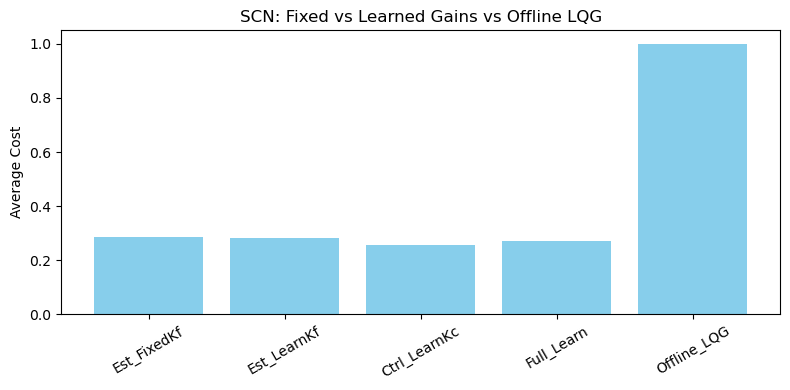

/var/folders/pn/y6zh5gpn3rs_kj7p71jpmybh0000gn/T/ipykernel_55718/2199964639.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


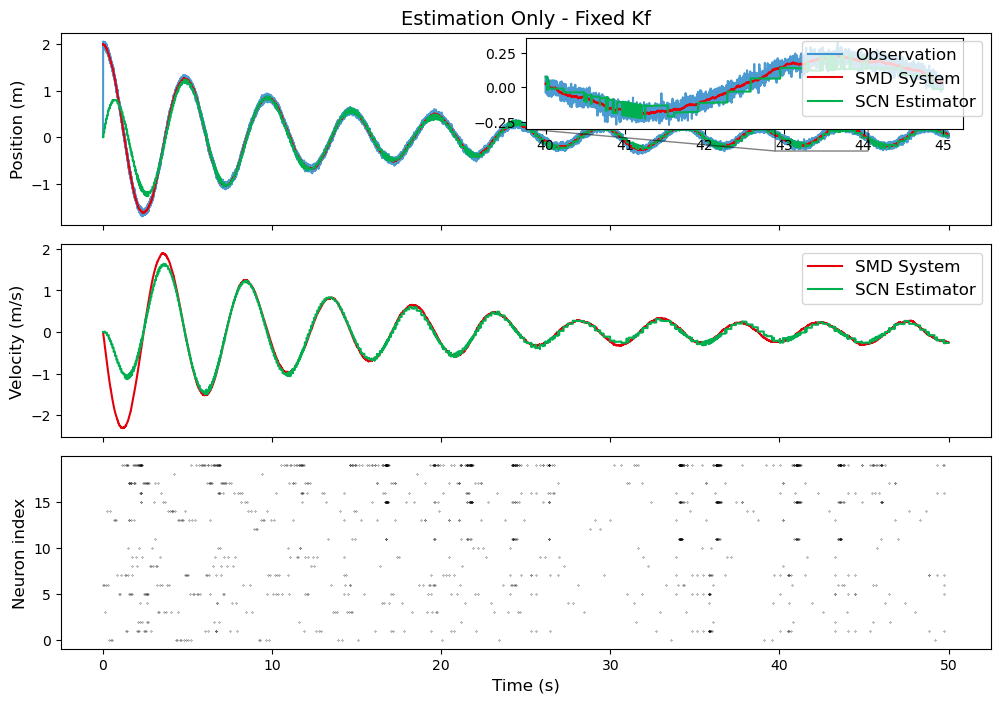

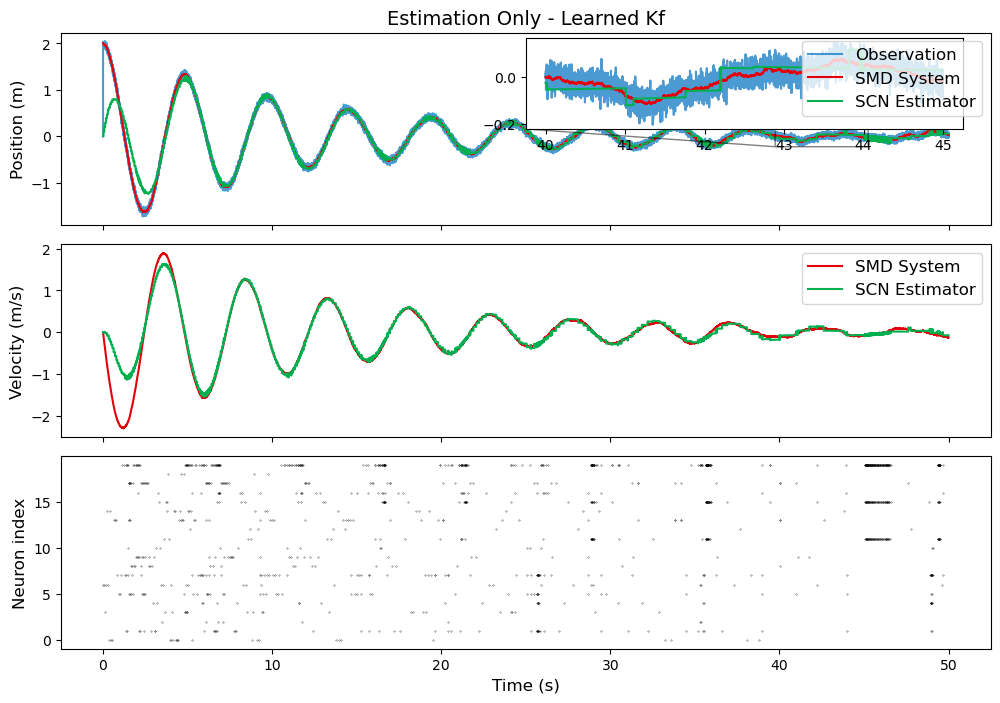

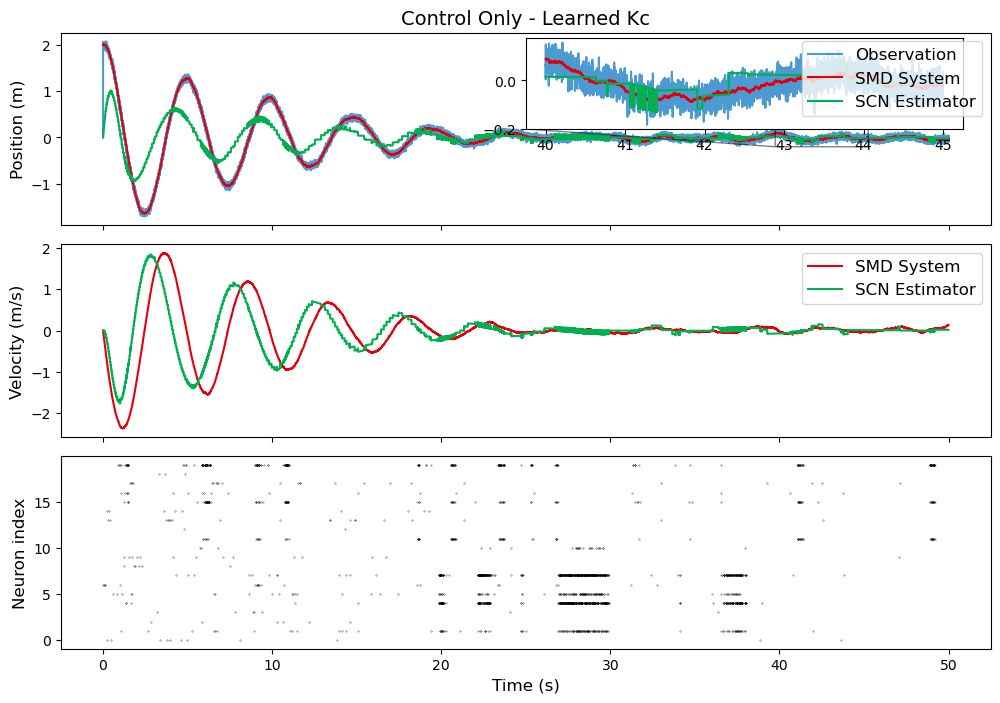

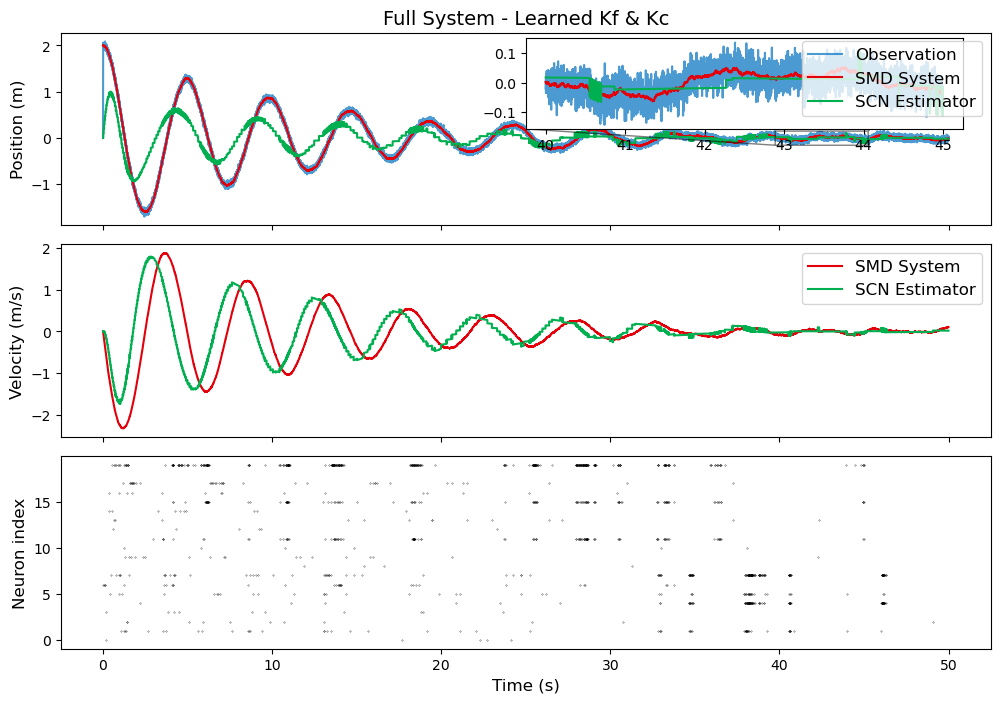

In [15]:
compare_fixed_vs_learned()